# Modeling of fluid channel from neutron images

This notebook is designed for analysis of neutron data of refrigerant
flowing through a microfluidic channel.

Created on Thu Feb 13 10:33:13 2020  
author: ericmuckley@gmail.com

### Import libraries

In [1]:
import os
import math
import itertools
import numpy as np
from glob import glob
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3

### Get image list

In [2]:
# set path of folder which contains image files
folder_path = os.path.join(os.getcwd(), 'data')
all_images = [f for f in glob(folder_path+'/*') if '.tif' in f]
print('Found {} images:'.format(len(all_images)))
for img in all_images:
    print(os.path.split(img)[1])

Found 17 images:
25lbhA0010.tif
25lbhA0020.tif
25lbhA0030.tif
25lbhA0040.tif
25lbhA0050.tif
25lbhA0060.tif
25lbhA0070.tif
75lbh000010.tif
75lbh000020.tif
75lbh000030.tif
75lbh000040.tif
75lbh000050.tif
75lbh000060.tif
75lbh000070.tif
75lbh000080.tif
75lbh000090.tif
75lbh000100.tif


### Define some functions to use later

In [3]:
def plot_setup(labels=['X', 'Y'], fsize=18, setlimits=False,
               limits=[0,1,0,1], title='', size=None,
               legend=False, save=False, filename='plot.jpg'):
    """Creates a custom plot configuration to make graphs look nice.
    This can be called with matplotlib for setting axes labels,
    titles, axes ranges, and the font size of plot labels.
    This should be called between plt.plot() and plt.show() commands."""
    plt.xlabel(str(labels[0]), fontsize=fsize)
    plt.ylabel(str(labels[1]), fontsize=fsize)
    plt.title(title, fontsize=fsize)
    fig = plt.gcf()
    if size:
        fig.set_size_inches(size[0], size[1])
    else:
        fig.set_size_inches(10, 10)
    if legend:
        plt.legend(fontsize=fsize-4)
    if setlimits:
        plt.xlim((limits[0], limits[1]))
        plt.ylim((limits[2], limits[3]))
    if save:
        fig.savefig(filename, dpi=120, bbox_inches='tight')
        plt.tight_layout()


def scale_image(image, scaling_factor=2):
    """Scale a 2D image using a scaling factor."""
    from skimage.transform import resize
    # get number of pixels in each dimension
    x_pixels = np.shape(image)[1]
    y_pixels = np.shape(image)[0]
    scaled_image  = resize(
        image, (scaling_factor*y_pixels, scaling_factor*x_pixels))
    return scaled_image


def plot_channel_image(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()


def get_bubble_profile(rad=10):
    """Get the 3D surface profile of a bubble using its radius,
    based on the equation of a sphere (x^2 + y^2 + z^2 = r^2)."""
    # create 2D x-y grid
    xgrid, ygrid = np.meshgrid(np.linspace(-rad, rad, num=1+2*rad),
                               np.linspace(-rad, rad, num=1+2*rad))
    # calculate value of 3D bubble surface based on equation of sphere
    z = np.sqrt(np.square(rad)-np.square(xgrid)-np.square(ygrid))
    # replace nan values with zeros
    return np.nan_to_num(z)

    
def add_bubble_to_grid(grid, bub_profile, rad=10, cent=(0,0)):
    """Add profile of the bubble to a simulated grid of possible bubbles."""
    # get limits of pixel coordinates
    xmax = len(grid[0])-1
    ymax = len(grid)-1
    # get slice indices of image which will be populated by bubble
    x1, x2 = cent[0]-rad, cent[0]+rad+1
    y1, y2 = cent[1]-rad, cent[1]+rad+1
    # trim bubble and image indices if bubble extends outside image range
    if x1 < 0:
        bub_profile = bub_profile[:, -x1:]
        x1 = 0
    if x2 > xmax:
        bub_profile = bub_profile[:, :-(x2-xmax)]
        x2 = xmax
    if y1 < 0:
        bub_profile = bub_profile[-y1:]
        y1 = 0
    if y2 > ymax:
        bub_profile = bub_profile[:-(y2-ymax)]
        y2 = ymax
    # add new bubble profile to existing grid
    grid_new = np.zeros_like(grid)
    grid_new[y1:y2, x1:x2] += bub_profile
    return grid_new

### Trim empty space out of images

The empty space around each channel is removed, and the inner channel
region is bordered by red lines in the plot below. Finally, the
inner channel region is isolated from the rest of the image to isolate
the area of interest. The void faction of each region of interest is
calculated so that  blue=0 and red=1.

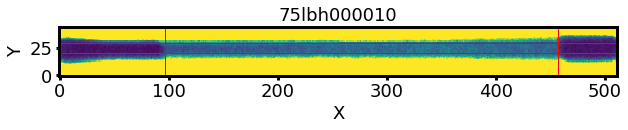

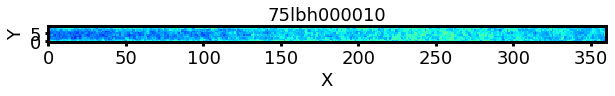

Trimmed image pixel shape: (10, 360)


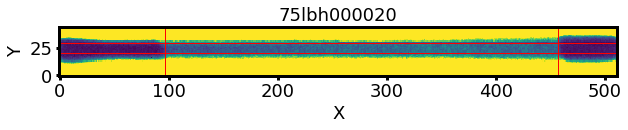

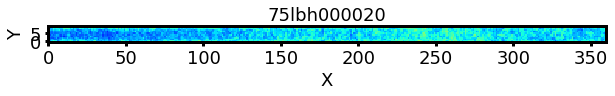

Trimmed image pixel shape: (10, 360)


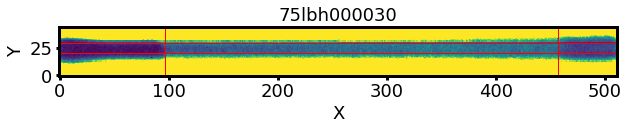

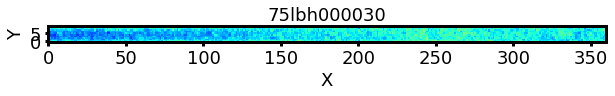

Trimmed image pixel shape: (10, 360)


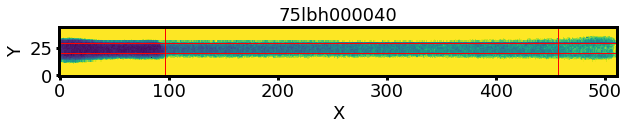

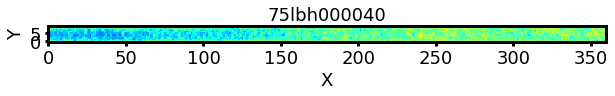

Trimmed image pixel shape: (10, 360)


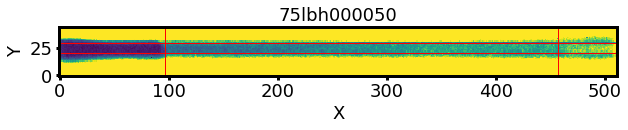

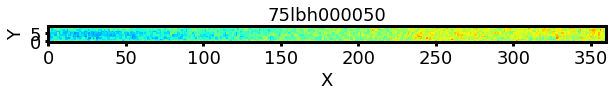

Trimmed image pixel shape: (10, 360)


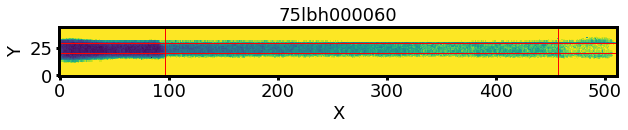

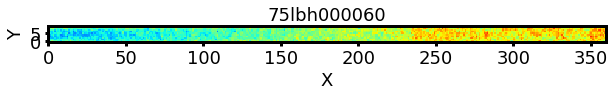

Trimmed image pixel shape: (10, 360)


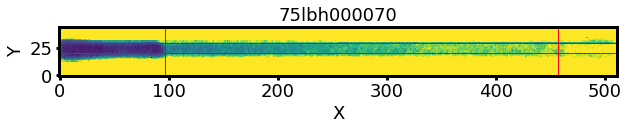

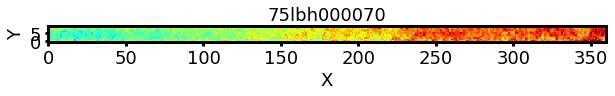

Trimmed image pixel shape: (10, 360)


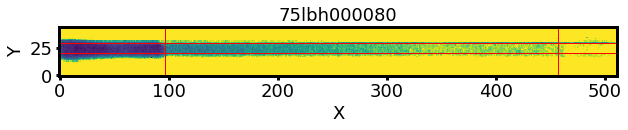

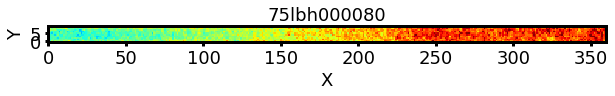

Trimmed image pixel shape: (10, 360)


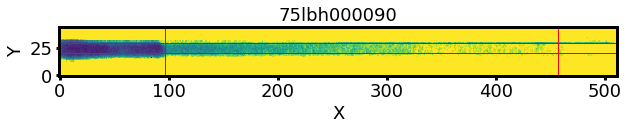

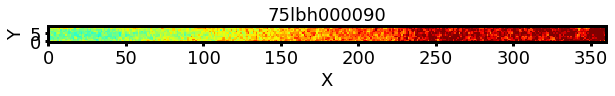

Trimmed image pixel shape: (10, 360)


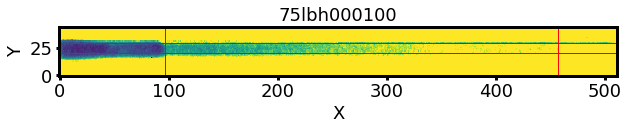

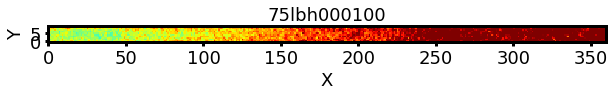

Trimmed image pixel shape: (10, 360)


In [4]:
# set vertical pixel limits that we want to select to remove aluminum area
rlims25 = [245, 280]
rlims75 = [225, 270]

# This section commented out because we are only looking at 75 lb flowrate
# images for now
# get list of all images and their titles
#img_names = [i for i in all_images if 'empty' not in i]
# get reference image as a 2D numpy array
#ref_img_name = [i for i in all_images if 'empty' in i][0]
#ref_img = plt.imread(ref_img_name)[:, :, 0].T[rlims75[0]:rlims75[1]]

# create dictionary to hold all trimmed images
img_dict = {}

# loop over each non-reference image
# look at only 75 lb flow rate images for now
img_names = sorted([i for i in all_images if '75' in i])

for img in img_names:
    
    # get flowrate and temperature from image names
    label = os.path.split(img)[1].split('.')[0]
    flowrate = int(label.split('lb')[0])
    # trim image based on the flow rate so that all images are centered
    if flowrate == 25:
        img_raw = plt.imread(img)[:, :, 0].T[rlims25[0]:rlims25[1]]
        temp = int(label.split('00')[-1])
        xlims = [68, 428]
        ylims= [15, 25]
    if flowrate == 75:
        img_raw = plt.imread(img)[:, :, 0].T[rlims75[0]:rlims75[1]]
        temp = int(label.split('000')[-1])
        xlims = [97, 457]
        ylims = [20, 30]
        
    # cut image to only include channel interior
    img_channel = img_raw[ylims[0]:ylims[1], xlims[0]:xlims[1]]

    # save results into dictionary
    img_dict[label] = {
            'flowrate': flowrate,
            'temp': temp,
            'img_raw': img_raw,
            'img_channel': img_channel,
            'img_voidfrac': img_channel/255} 

    # plot results
    show_full_image = True
    show_channel_image = True
    if show_full_image:
        # plot horizontal bounding lines
        plt.axvline(x=xlims[0], color='r', lw=1)
        plt.axvline(x=xlims[1], color='r', lw=1)
        # plot vertical bounding lines
        plt.axhline(y=ylims[0], color='r', lw=1)
        plt.axhline(y=ylims[1], color='r', lw=1)
        plt.imshow(img_raw, origin='lower', vmin=0, vmax=255)
        plt.title(label)
        plot_setup(title=label)
        plt.show()
    if show_channel_image:
        plt.imshow(img_channel/255, origin='lower',
                   vmin=0, vmax=1, cmap='jet')
        plot_setup(title=label)
        plt.show()
        print('Trimmed image pixel shape: {}'.format(np.shape(img_channel)))
    print('==============================================================')

# save trimmed channel images to numpy file
save_img_path = os.path.join(os.getcwd(), 'trimmed_images.npy')
np.save(save_img_path, img_dict)

## Prepare physical modeling problem

First we determine the possible frequencies of occurence of each type of
bubble inside a given area. We take all combinations of possible bubbles, and
based on their diameters, remove possibilities which are not physically
relevant (i.e. multiple large bubbles together which will not fit inside a
given area.) The physical relevance is based on maximum and minimum
possible bubble diameters, number of distinct bubble sizes we want to search
for, and the physical channel dimensions.

In [5]:
"""
Previous parameters which yielded accurate modeling results:
channel = {'w': 22000, 'h': 250, 'd': 750}
bubble = {'min_rad': 1, 'max_rad': 60, 'buffer': 1}
img = scale_image(img, scaling_factor=int(0.1*channel['w']/len(img[0])))
plot_channel_image(img, title='Rescaled image', vmin=0, vmax=1)
max_bubbles = 1000000
"""

# define channel dimensions (width, height, depth) in μm
channel = {'w': 22000, 'h': 250, 'd': 750}

# define bubble radius limits and min buffer distance between bubbles in μm
bubble = {'min_rad': 1, 'max_rad': 60, 'buffer': 1}

## Read in trimmed images and execute model 

Now that we have trimmed, formatted, and exported the images, we can import them again as a single dictionary. Then we model each image to find configurations of bubbles which replicate the original images.

In [6]:
# load dictionary from json file
img_dict_path = os.path.join(os.getcwd(), 'trimmed_images.npy')
img_dict = np.load(img_dict_path, allow_pickle=True)[()]

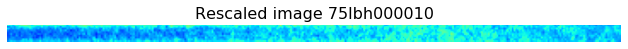

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


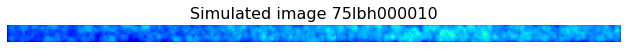

total bubbles: 2482, runtime (min): 0.3, error (%): 22.67
--------------------------------------------------------------



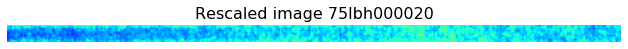

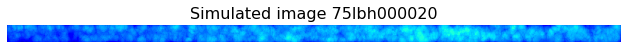

total bubbles: 2438, runtime (min): 0.6, error (%): 23.0
--------------------------------------------------------------



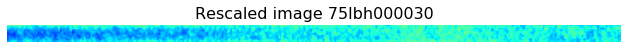

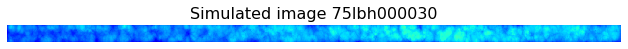

total bubbles: 2435, runtime (min): 0.8, error (%): 21.64
--------------------------------------------------------------



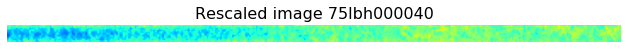

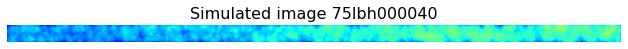

total bubbles: 2590, runtime (min): 1.0, error (%): 21.26
--------------------------------------------------------------



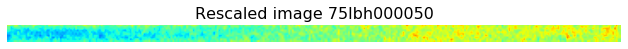

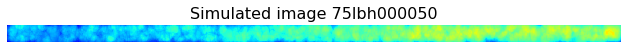

total bubbles: 2741, runtime (min): 1.3, error (%): 19.88
--------------------------------------------------------------



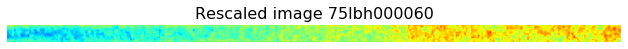

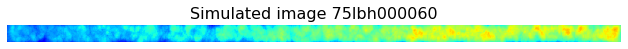

total bubbles: 2851, runtime (min): 1.6, error (%): 19.86
--------------------------------------------------------------



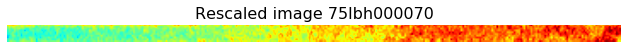

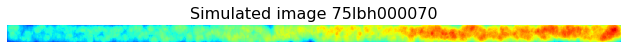

total bubbles: 2960, runtime (min): 1.9, error (%): 18.51
--------------------------------------------------------------



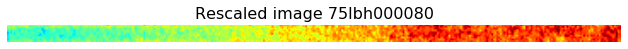

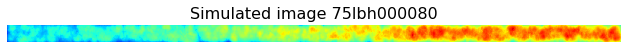

total bubbles: 2983, runtime (min): 2.1, error (%): 18.58
--------------------------------------------------------------



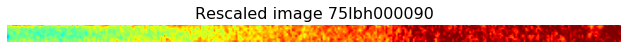

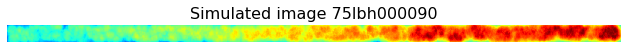

total bubbles: 3125, runtime (min): 2.3, error (%): 17.64
--------------------------------------------------------------



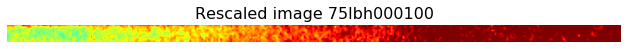

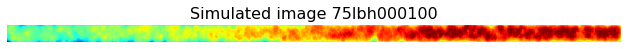

total bubbles: 3181, runtime (min): 2.5, error (%): 17.11
--------------------------------------------------------------



In [7]:
starttime = time()

# set parameters for monte carlo simulation
max_bubbles = 10000  # max number of bubbles to add to simulation
#tot_trials = 3  # total trials to run for each image

# loop over each image
for L in list(img_dict):

    # get target image, rescale so we can work with more pixels, and plot it
    img = img_dict[L]['img_voidfrac']
    img = scale_image(img, scaling_factor=int(0.1*channel['w']/len(img[0])))
    plot_channel_image(img, title='Rescaled measured image '+L, vmin=0, vmax=1)

    #for trial_i in range(tot_trials):

    # simulate empty channel to populate with simulated bubbles
    sim = {
        'label': L,
        'img': np.zeros(img.shape),
        'cent': [],
        'rad': []}
    
    # the simulated image
    simg = sim['img']

    # get limits of pixel coordinates
    xmax, ymax = len(simg[0])-1, len(simg)-1

    # generate array of random bubble centers and radii for seeding simulation
    cent_list = np.zeros((max_bubbles, 2)).astype(int)
    cent_list[:, 0] = np.random.randint(0, len(simg[0]), size=(max_bubbles))
    cent_list[:, 1] = np.random.randint(0, len(simg), size=(max_bubbles))
    rad_list = np.random.randint(
        bubble['min_rad'], bubble['max_rad'], size=(max_bubbles))

    # loop over bubbles and populate simulation
    for b in range(max_bubbles):

        # get random bubble radius and center and scale by channel depth
        rad = rad_list[b]
        cent = cent_list[b]
        bub_profile = get_bubble_profile(rad=rad) / channel['d']

        # get slice indices of image which will be populated by bubble
        x1, x2 = cent[0]-rad, cent[0]+rad+1
        y1, y2 = cent[1]-rad, cent[1]+rad+1
        # trim bubble and image indices if bubble extends outside image range
        if x1 < 0:
            bub_profile = bub_profile[:, -x1:]
            x1 = 0
        if x2 > xmax:
            bub_profile = bub_profile[:, :-(x2-xmax)]
            x2 = xmax
        if y1 < 0:
            bub_profile = bub_profile[-y1:]
            y1 = 0
        if y2 > ymax:
            bub_profile = bub_profile[:-(y2-ymax)]
            y2 = ymax
        
        # add new bubble profile to existing simulation if it will fit
        # first check if radius will fit at that specific center
        current_val = simg[cent[1], cent[0]]
        if current_val + 2*rad/channel['d'] <= img[cent[1], cent[0]]:
        # then check if the whole bubble will fit
            new_profile = np.zeros(simg.shape)
            new_profile[y1:y2, x1:x2] += bub_profile 

            # if entire bubble fits, save its stats and add it to model
            if np.all(simg + new_profile <= 1.02*img):
                simg[y1:y2, x1:x2] += bub_profile 
                sim['cent'].append(cent)
                sim['rad'].append(rad)

    #print('trial {}/{}:'.format(trial_i+1, tot_trials))
    tot_err = np.mean(np.abs(img - simg)/img)*100
    sim['tot_err_percent'] = tot_err
    plot_channel_image(sim['img'], title='Simulated image '+L, vmin=0, vmax=1)
    print('total bubbles: {}, runtime (min): {}, error (%): {}'.format(
        len(sim['rad']),
        round((time() - starttime)/60,1),
        round(tot_err, 2)))
    print('--------------------------------------------------------------\n')


    # save model to file and download the file to local machine
    save_model_path = os.path.join(os.getcwd(), 'models', L + '__model.npy')
    np.save(save_model_path, sim)

## Read models and reconstruct simulated channels

In [13]:
def remove_axis_backgrounds(ax, grid=True):
    """Takes matplotlib 3D axis and removes colored plane backgrounds.
    Also turns on or off the gridlines in 3D plot."""
    if grid is False:
        ax.grid(b=None)
    # remove colored axes planes
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    # set axis plane color to white
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

In [ ]:
# get list of all existing models
models = [f for f in glob(os.path.join(os.getcwd(), 'models')+'/*') if '.npy' in f]

# loop over each model file and plot it
for model in models[-3:]:

    m = np.load(model, allow_pickle=True)[()]

    

    r = np.array(m['rad'])
    x0 = np.array(m['cent'])[:, 0]
    y0 = np.array(m['cent'])[:, 1]
    z0 = np.zeros_like(m['rad'])#np.random.randint(1, 100, size=num)#[2, 0, 1]

    
    

    fig = plt.figure()
    fig.set_size_inches(8, 4)
    #fig.tight_layout()
    ax = fig.gca(projection='3d')
    #ax.set_aspect("equal")
    #ax.auto_scale_xyz([0, 500], [0, 500], [0, 100]
    u, v = np.mgrid[0:2*np.pi:5j, 0:np.pi:5j]

    for i in range(len(r)):

        # draw sphere
        x = r[i]*np.cos(u)*np.sin(v)+x0[i]
        y = r[i]*np.sin(u)*np.sin(v)+y0[i]
        z = r[i]*np.cos(v)+z0[i]
        ax.plot_surface(x, y, z, color='gray')#, alpha=0.5)
    
    # create cubic bounding box to simulate equal aspect ratio
    max_range = np.array([x0.max()-x0.min(), y0.max()-y0.min(), z0.max()-z0.min()]).max()
    Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x0.max()+x0.min())
    Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y0.max()+y0.min())
    Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z0.max()+z0.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
       ax.plot([xb], [yb], [zb], 'w')


    remove_axis_backgrounds(ax)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    
    
    plt.title(m['label'])

    plt.show()


## Examine statistics of bubble distribution

In [11]:

def reconstruct_image(sim):
    # loop over every bubble and reconstruct the image
    reconstructed_img = np.zeros_like(sim['img'])
    for i in range(len(sim['rad'])):
        cent = sim['cent'][i]
        bub_profile = get_bubble_profile(
            rad=sim['rad'][i]) / channel['d']
        reconstructed_img = add_bubble_to_grid(
            reconstructed_img,
            bub_profile,
            rad=sim['rad'][i],
            cent=sim['cent'][i])
    plot_channel_image(reconstructed_img, vmin=0, vmax=1)


def get_stats(arr):
    """Return stats of an array in dictioary form."""
    d = {'min': np.min(arr), 'max': np.max(arr),
         'mean': np.mean(arr), 'median': np.median(arr), 'std': np.std(arr)}
    return d


def simulation_report(sim):
    """Create histograms which summarize statistics of the simulation."""
    # plot histogram of bubble radii
    d = get_stats(sim['rad'])
    print('Radius statistics:')
    [print('{}: {}'.format(key, val)) for key, val in d.items()]
    plt.hist(sim['rad'], bins=60)
    plot_setup(title='Distribution of bubble radii',
            labels=['Radius (μm)', 'Frequency'], size=(5, 3))
    plt.show()

    # plot histogram of bubble center y-values
    yvals = [pair[1] for pair in sim['cent']]
    plot_setup(title='Bubble positions perpendicular to channel',
            labels=['Position (μm)', 'Frequency'], size=(5, 3))
    plt.hist(yvals, bins=60)
    plt.show()
    # plot histogram of bubble center x-values
    xvals = [pair[0] for pair in sim['cent']]
    plot_setup(title='Bubble positions parallel to channel',
            labels=['Position (μm)', 'Frequency'], size=(5, 3))
    plt.hist(xvals, bins=60)
    plt.show()

#simulation_report(sim)